In [1]:
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from corner import corner

mpl.rcParams["text.latex.preamble"] = r"\usepackage{newtxtext,newtxmath}"
mpl.rcParams["font.size"] = 12

%matplotlib inline

In [2]:
data_simple = az.from_netcdf('data/hbm-simple.nc')
data_hbm = az.from_netcdf('data/hbm-hierarchical.nc')
num_obs = data_simple.posterior.dims["Star"]

In [3]:
truth = pd.read_csv('data/hbm-inputs.csv', index_col=0)
truth.head()

,d,abs_mag,par,mag,par_obs,mag_obs
Star,,,,,,
0,9.959026,-1.275786,0.100411,3.715298,0.094393,3.562791
1,10.173046,0.309822,0.098299,5.347077,0.092023,5.352257
2,10.120465,-0.684417,0.098810,4.341586,0.105925,4.364776
3,9.895651,0.753958,0.101055,5.731180,0.115520,5.987240
4,10.102282,0.700781,0.098988,5.722878,0.096356,5.645176


In [4]:
df = pd.concat(
    {
        "Simple": data_simple.posterior.to_dataframe(), 
        "HBM": data_hbm.posterior.to_dataframe()
    },
    names=["Model"]
).reset_index().merge(truth, on="Star", how="outer", suffixes=("", "_true"))
df.head()

,Model,chain,draw,Star,abs_mag,d,mag,par,_d,mu_d,sigma_d,d_true,abs_mag_true,par_true,mag_true,par_obs,mag_obs
0,Simple,0,0,0,-1.495262,10.047164,3.514955,0.099531,NaN,NaN,NaN,9.959026,-1.275786,0.100411,3.715298,0.094393,3.562791
1,Simple,0,1,0,-1.677355,10.827124,3.495210,0.092361,NaN,NaN,NaN,9.959026,-1.275786,0.100411,3.715298,0.094393,3.562791
2,Simple,0,2,0,-1.543250,10.993447,3.662419,0.090963,NaN,NaN,NaN,9.959026,-1.275786,0.100411,3.715298,0.094393,3.562791
3,Simple,0,3,0,-1.429667,9.591224,3.479703,0.104262,NaN,NaN,NaN,9.959026,-1.275786,0.100411,3.715298,0.094393,3.562791
4,Simple,0,4,0,-1.767444,11.283726,3.494818,0.088623,NaN,NaN,NaN,9.959026,-1.275786,0.100411,3.715298,0.094393,3.562791


TODO: Consider common_norm=False in KDE.

In [5]:
def plot_residual(df, y, ylabel=None, legend=True, axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(6.4, 3.2), sharey=True,
                                gridspec_kw={"width_ratios": [3, 1], "wspace": 0.06})
    else:
        fig = plt.gcf()
    
    df = df.copy()
    df["res"] = df[y] - df[f"{y}_true"]
    ax = sns.violinplot(
        df, x="Star", y="res", hue="Model", saturation=1.0,
        scale="width", split=True, linewidth=0., ax=axes[0]
    )
    
    obs = f"{y}_obs"
    if obs in truth.columns:
        ax.plot(truth.index, truth[obs] - truth[y], ".k",
                label="Observed", markerfacecolor="none")
        # ax.legend()
    
    if not legend:
        ax.get_legend().remove()
    
    ax = sns.kdeplot(df, y="res", hue="Model", fill=True, ax=axes[1], legend=legend)
    ax.set_xticks([])
    ax.set_xlabel(None)
    if ylabel is not None:
        for ax in axes:
            ax.set_ylabel(ylabel)

    return fig, axes

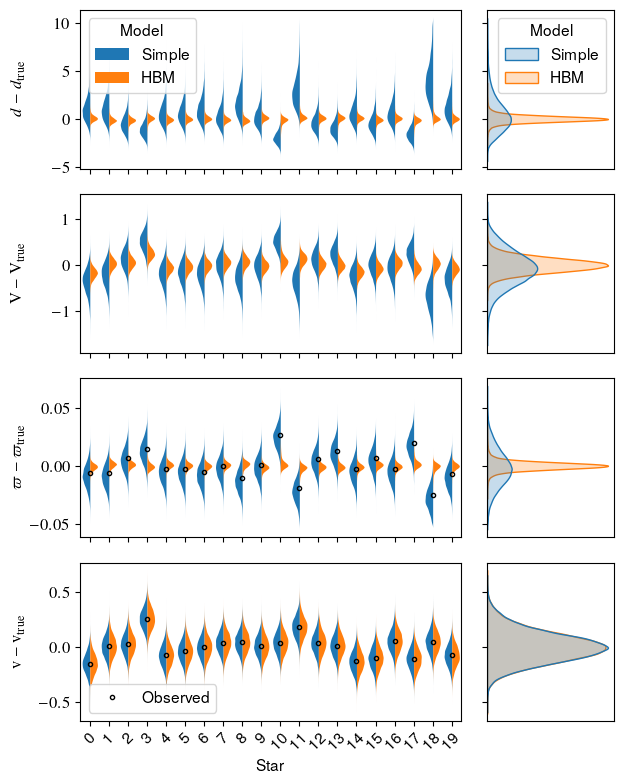

In [8]:
labelrotation = 45
with plt.rc_context({
    "text.usetex": True,  # Takes bloody ages for first time but good for thesis
}):
    fig, axes = plt.subplots(4, 2, figsize=(6.4, 8), sharey="row",
                            gridspec_kw={"width_ratios": [3, 1]})

    ax0 = axes[-1]
    _, ax0 = plot_residual(df, "mag", ylabel=r"$\mathrm{v} - \mathrm{v_{true}}$", axes=ax0, legend=False)
    ax0[0].tick_params(axis='x', labelrotation=labelrotation)
    ax0[0].legend(handles=[ax0[0].get_lines()[-1]], loc="lower left")

    ax = axes[-2]
    ax[0].sharex(ax0[0])
    _, ax = plot_residual(df, "par", ylabel=r"$\varpi - \varpi_\mathrm{true}$", axes=ax, legend=False)
    ax[0].set_xlabel(None)
    ax[0].tick_params(axis='x', labelbottom=False)

    ax = axes[-3]
    ax[0].sharex(ax0[0])
    _, ax = plot_residual(df, "abs_mag", ylabel=r"$\mathrm{V} - \mathrm{V_{true}}$", axes=ax, legend=False)
    ax[0].set_xlabel(None)
    ax[0].tick_params(axis='x', labelbottom=False)

    ax = axes[-4]
    ax[0].sharex(ax0[0])
    _, ax = plot_residual(df, "d", ylabel=r"$d - d_\mathrm{true}$", axes=ax)
    ax[0].set_xlabel(None)
    ax[0].tick_params(axis='x', labelbottom=False)
    fig.align_ylabels()
    fig.tight_layout()
    fig.savefig("../figures/hbm-results.pdf", format="pdf", dpi=300)

In [6]:
htruths = {"mu_d": 10.0, "sigma_d": 0.1}

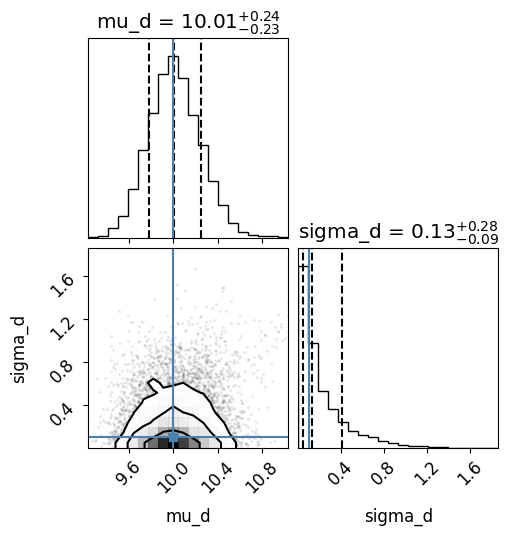

In [14]:
fig = corner(
    data_hbm, 
    var_names=["mu_d", "sigma_d"], 
    truths=htruths,
    show_titles=True,
    quantiles=[.16, .5, .84]
)

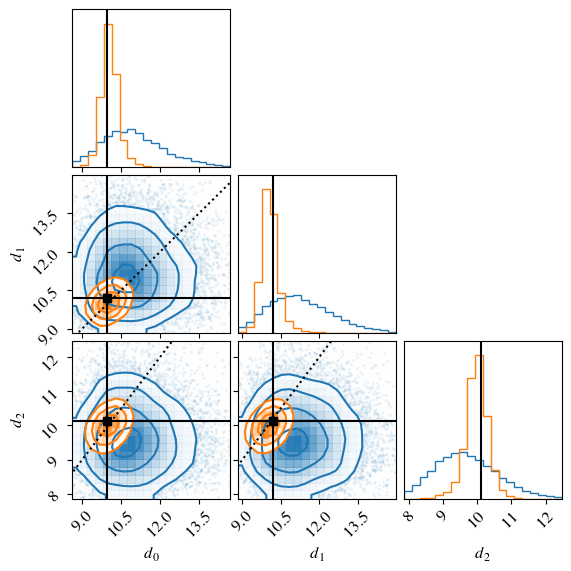

In [11]:
ndim = 3
stars = np.arange(ndim)
var_names = ["d"]
labels = [f"$d_{i}$" for i in stars]
coords = {"Star": stars}
rlim = data_simple.posterior.d.sel(Star=stars).quantile(
    [.01, .99], dim=("chain", "draw")
).T
smooth = 1

with plt.rc_context({
    "text.usetex": True,  # Takes bloody ages for first time but good for thesis
}):
    fig = plt.figure(figsize=(6, 6))
    fig = corner(
        data_simple, 
        var_names=var_names,
        labels=labels,
        coords=coords,
        smooth=smooth,
        range=rlim,
        color="C0",
        fig=fig,
    )

    fig = corner(
        data_hbm, 
        var_names=var_names,
        labels=labels,
        coords=coords,
        range=rlim,
        smooth=smooth,
        color="C1",
        truths={"d": truth.loc[stars, "d"]},
        truth_color="k",
        fig=fig,
    )

    # neat bit of code for setting limits after the fact
    # prob easier/slower to just reshape the axes though lol
    ti, tj = np.tril_indices(ndim)
    ltri = ndim*ti + tj
    di, dj = np.diag_indices(ndim)
    diag = ndim*di + dj
    for i, ax in enumerate(fig.get_axes()):
        if i not in ltri:
            # continue if not in lower triangle
            continue
        ax.set_xlim(rlim[i%ndim])
        if i not in diag:
            # ylim of diag should be unchanged
            ax.plot([7.5, 15], [7.5, 15], "k:")
            ax.set_ylim(rlim[i//ndim])

    fig.savefig("../figures/hbm-dist-corr.pdf", format="pdf", dpi=300)

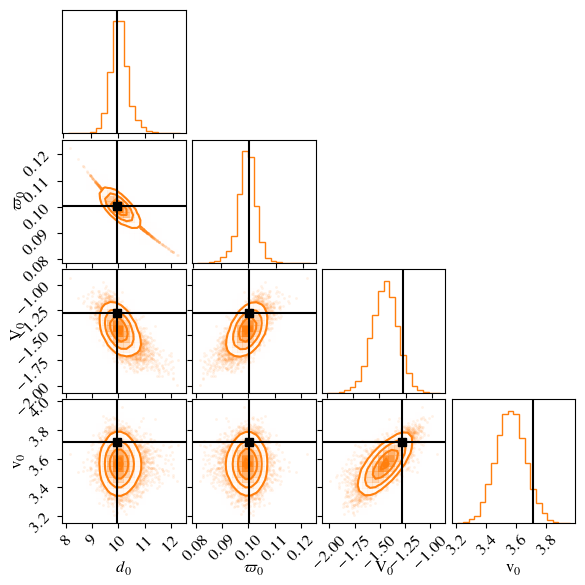

In [21]:
ndim = 3
star = 0
var_names = ["d", "par", "abs_mag", "mag"]
labels = [rf"$d_{star}$", rf"$\varpi_{star}$", rf"$\mathrm{{V}}_{star}$", rf"$\mathrm{{v}}_{star}$"]
coords = {"Star": [star]}
# rlim = data_simple.posterior.d.sel(Star=stars).quantile(
    # [.01, .99], dim=("chain", "draw")
# ).T
smooth = 1

with plt.rc_context({
    "text.usetex": True,  # Takes bloody ages for first time but good for thesis
}):
    fig = plt.figure(figsize=(6, 6))
    # fig = corner(
    #     data_simple, 
    #     var_names=var_names,
    #     labels=labels,
    #     coords=coords,
    #     smooth=smooth,
    #     # range=rlim,
    #     color="C0",
    #     fig=fig,
    # )

    fig = corner(
        data_hbm, 
        var_names=var_names,
        labels=labels,
        coords=coords,
        # range=rlim,
        smooth=smooth,
        color="C1",
        truths=truth.loc[star, var_names].to_dict(),
        truth_color="k",
        fig=fig,
    )

    # neat bit of code for setting limits after the fact
    # prob easier/slower to just reshape the axes though lol
    # ti, tj = np.tril_indices(ndim)
    # ltri = ndim*ti + tj
    # di, dj = np.diag_indices(ndim)
    # diag = ndim*di + dj
    # for i, ax in enumerate(fig.get_axes()):
    #     if i not in ltri:
    #         # continue if not in lower triangle
    #         continue
    #     ax.set_xlim(rlim[i%ndim])
    #     if i not in diag:
    #         # ylim of diag should be unchanged
    #         ax.set_ylim(rlim[i//ndim])

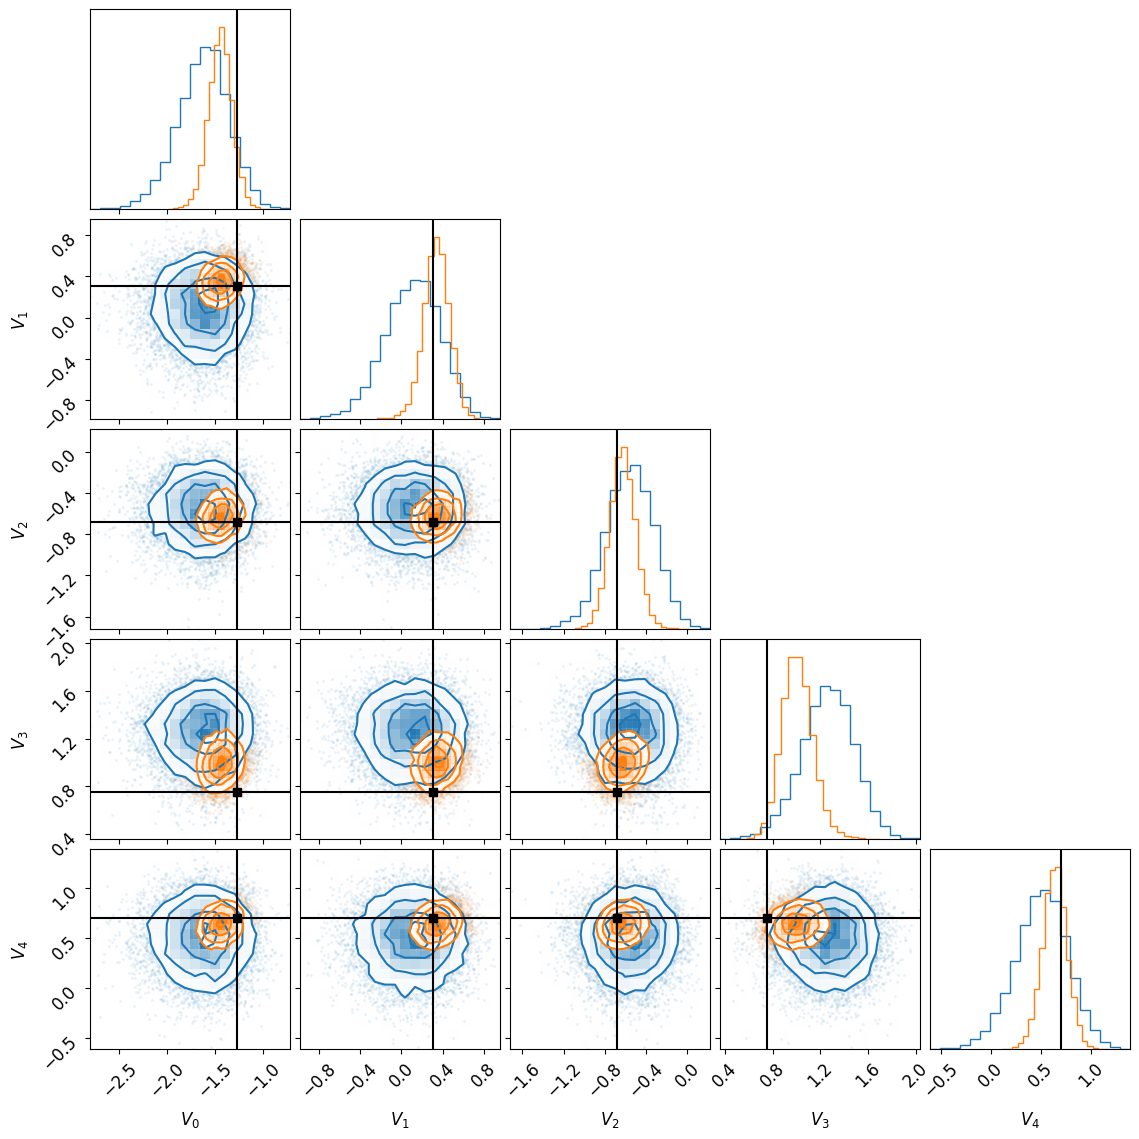

In [17]:
stars = np.arange(5)
var_names = ["abs_mag"]
labels = [f"$V_{i}$" for i in stars]
coords = {"Star": stars}

fig = corner(
    data_simple, 
    var_names=var_names,
    labels=labels,
    coords=coords,
    color="C0",
)

fig = corner(
    data_hbm, 
    var_names=var_names,
    labels=labels,
    coords=coords,
    color="C1",
    truths={"abs_mag": truth.loc[stars, "abs_mag"]},
    truth_color="k",
    fig=fig
)

In [11]:
data_simple.posterior["mu_d"] = data_simple.posterior.d.mean(dim="Star")
data_simple.posterior["sigma_d"] = data_simple.posterior.d.std(dim="Star", ddof=1)

data_simple.posterior["log_sigma_d"] = np.log10(data_simple.posterior.sigma_d)
data_hbm.posterior["log_sigma_d"] = np.log10(data_hbm.posterior.sigma_d)
htruths["log_sigma_d"] = np.log10(htruths["sigma_d"])

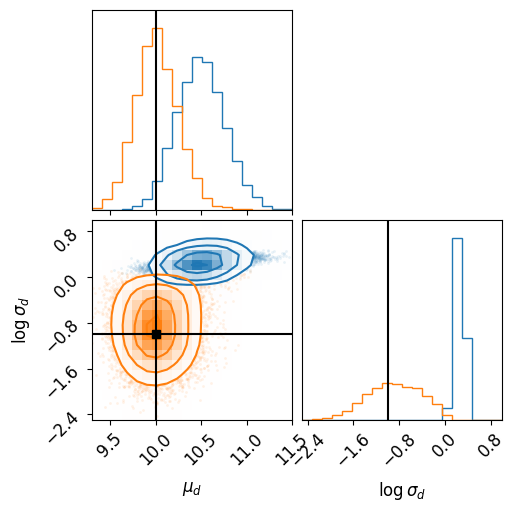

In [12]:
var_names = ["mu_d", "log_sigma_d"]
labels = [r"$\mu_d$", r"$\log\sigma_d$"]
rlim = [(9.3, 11.5), (-2.5, 1.)]

fig = corner(
    data_simple,
    var_names=var_names,
    range=rlim,
    color="C0",
    smooth=smooth,
    labels=labels,
)

fig = corner(
    data_hbm, 
    var_names=var_names, 
    truths=htruths,
    truth_color="k",
    range=rlim,
    color="C1",
    smooth=smooth,
    labels=labels,
    fig=fig,
)

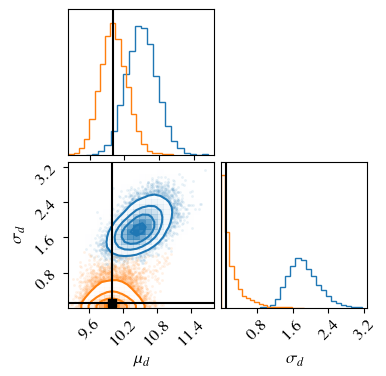

In [13]:
var_names = ["mu_d", "sigma_d"]
labels = [r"$\mu_d$", r"$\sigma_d$"]
rlim = None
smooth = 1

with plt.rc_context({
    "text.usetex": True,  # Takes bloody ages for first time but good for thesis
}):
    fig = plt.figure(figsize=(4, 4))
    fig = corner(
        data_simple,
        var_names=var_names,
        range=rlim,
        color="C0",
        smooth=smooth,
        labels=labels,
        fig=fig,
    )

    fig = corner(
        data_hbm, 
        var_names=var_names, 
        truths=htruths,
        truth_color="k",
        range=rlim,
        color="C1",
        smooth=smooth,
        labels=labels,
        fig=fig,
    )
    fig.savefig("../figures/hbm-global.pdf", format="pdf", dpi=300)

In [66]:
az.summary(data_simple, var_names=var_names, round_to=5,
           stat_funcs={
               "median": np.median, 
               "lower": lambda x: np.median(x) - np.quantile(x, 0.16), 
               "upper": lambda x: np.quantile(x, 0.84) - np.median(x)
            })

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,lower,upper
mu_d,10.49761,0.26609,10.00822,10.99731,0.00296,0.00210,8147.19492,7302.55133,1.00100,10.49392,0.26391,0.26937
sigma_d,1.84358,0.32868,1.26524,2.47927,0.00489,0.00363,4915.23809,3509.37565,1.00086,1.81504,0.29343,0.36019


In [67]:
az.summary(data_hbm, var_names=var_names, round_to=5,
           stat_funcs={
               "median": np.median, 
               "lower": lambda x: np.median(x) - np.quantile(x, 0.16), 
               "upper": lambda x: np.quantile(x, 0.84) - np.median(x)
            })

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,lower,upper
mu_d,10.01418,0.23637,9.58528,10.46361,0.00433,0.00308,3125.15132,3589.04355,1.00203,10.00650,0.22628,0.24225
sigma_d,0.21656,0.22474,0.00291,0.66416,0.00757,0.00535,1253.51858,1303.75232,1.00500,0.13102,0.08838,0.28025


In [78]:
data_simple.posterior.d.std(dim=("chain", "draw")).median()

<xarray.DataArray 'd' ()>
array(1.1576602, dtype=float32)

In [77]:
data_hbm.posterior.d.std(dim=("chain", "draw")).median()

<xarray.DataArray 'd' ()>
array(0.3512004, dtype=float32)